<a href="https://colab.research.google.com/github/gabrielmelo00/Machine-Learning-Projects/blob/main/Autoencoder_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lucas Oliveira Machado de Sousa
# Gabriel Silva Vieira de Melo

<h1><center>Autoencoder on MNIST using Keras<center></h1>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Importing Keras

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
print("Using tensorflow version " + str(tf.__version__))
print("Using keras version " + str(keras.__version__))

Using tensorflow version 2.8.0
Using keras version 2.8.0


## Loading and preparing the MNIST dataset

Load the MNIST dataset via keras.datasets. Again, turn train and test labels into one-hot encoding, and reshape and normalize data as in the first exercise. 

In [ ]:
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g., ImageNet)
from keras.datasets import mnist
# START CODE HERE
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)
# END CODE HERE

In [ ]:
# Do you remember about one-hot encoding ?
from keras.utils.np_utils import to_categorical
# START CODE HERE
train_labels = to_categorical(y_train, num_classes=10)
test_labels = to_categorical(y_test, num_classes=10)
# END CODE HERE


In [ ]:
# Reshape to proper images with 1 color channel according to backend scheme
img_rows, img_cols = x_train.shape[1], x_train.shape[2]
train_images = x_train.reshape(x_train.shape[0], img_rows * img_cols)

# START CODE HERE
test_images = x_test.reshape(x_test.shape[0], img_rows * img_cols)
# END CODE HERE

# Cast pixels from uint8 to float32
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')


# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time ?
# START CODE HERE
from sklearn.preprocessing import StandardScaler

u = np.mean(train_images)
s = np.std(train_images)

train_images = (train_images - u)/s
test_images = (test_images - u)/s

# END CODE HERE

## Autoencoder and PCA

First, we will try to connect the representation produced by Principal Component Analysis with what is learnt by a simple, linear, autoencoder. We will use the ```scikit-learn``` implementation of the ```PCA``` to obtain the two first components (hint: use the attribute ```.components_```), and visualize them:

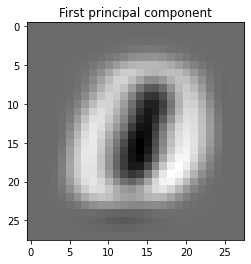

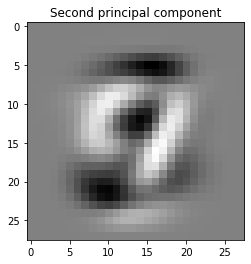

In [ ]:
from sklearn.decomposition import PCA

# Let's find the first 2 PCA components
num_components = 2
# START CODE HERE
pca = PCA(random_state=0)
Ypca = pca.fit_transform(train_images)
U = pca.components_.T[:,0:num_components]
# END CODE HERE

# Reshape so they resemble images and we can print them
# START CODE HERE
PC1 = U[:,0].reshape((28,28))
PC2 = U[:,1].reshape((28,28))
# END CODE HERE

# Show the reshaped principal components
# START CODE HERE
plt.figure()
plt.imshow(PC1, cmap='gray')
plt.title("First principal component")

plt.figure()
plt.imshow(PC2, cmap='gray')
plt.title("Second principal component")

plt.show()

# END CODE HERE

The percentage of the variance explained by the first two components is  16.800588369369507 %


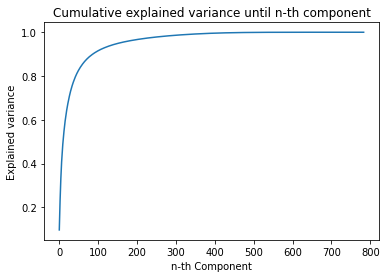

In [ ]:
# Print the variance explained by those components
expVar = pca.explained_variance_
print("The percentage of the variance explained by the first two components is ", (expVar[0]+expVar[1])/expVar.sum()*100, "%")
plt.plot(np.cumsum(expVar)/expVar.sum())
plt.xlabel('n-th Component')
plt.ylabel('Explained variance')
plt.title("Cumulative explained variance until n-th component")
plt.show()

**Comment on the visualization in relation to the variance explained by only keeping the two principal components.**

Now, we will use Keras to implement the autoencoder. You can take a look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf) for some basic commands to use keras.

In this first case, we implement a **simple linear autoencoder**. Build it in order to have the same capacity as the PCA decomposition (2 hidden dimensions !) we made just above. 

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD, Adam

In [ ]:
# Input layer
input_layer = Input(shape=(784,))

# Encoding layer
latent_view = Dense(2)(input_layer)

# Decoding layer
output_layer = Dense(784)(latent_view)

In [ ]:
ae_model = Model(input_layer, output_layer, name='ae_model')
ae_model.summary()

Model: "ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_68 (Dense)            (None, 2)                 1570      
                                                                 
 dense_69 (Dense)            (None, 784)               2352      
                                                                 
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________


What loss shoud we use ? Choose the usual one and import it directly from Keras. You can use a simple ```SGD``` optimizer, and then compile the model; finally, train it to rebuild images from the original examples.  

**Answer:** We should use the Mean Square error. Since our data is standardized and the model is linear, the encoder corresponds to the PCA. Also, the linear encoder is optimal for minimizing the training square error.

In [ ]:
from tensorflow.keras.losses import mse

loss = 'MSE'
optimizer = SGD(learning_rate=1e-1) 

ae_model.compile(optimizer=optimizer, loss=loss)

In [ ]:
batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(train_images,
                       train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images, test_images))

Epoch 1/10
469/469 [==============================] - 2s 4ms/step - loss: 0.7472 - val_loss: 0.6707
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6456 - val_loss: 0.6266
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6230 - val_loss: 0.6199
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6193 - val_loss: 0.6178
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6179 - val_loss: 0.6168
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6172 - val_loss: 0.6162
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6167 - val_loss: 0.6158
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6164 - val_loss: 0.6155
Epoch 9/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6162 - val_loss: 0.6154
Epoch 10/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6159 - val_loss: 0.6152

Assuming that the name of your layer (obtained through the command ```model.summary()```) is ```'layer'```, here is the way to obtained the weights. Visualize the weights of the encoder and compare them to the two components obtained through the PCA.

In [ ]:
layer_names = [layer.name for layer in ae_model.layers]
weights, bias = ae_model.get_layer(layer_names[1]).get_weights()

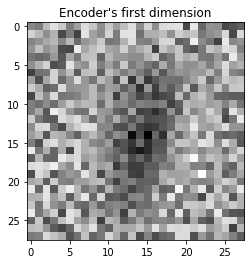

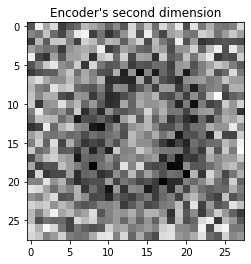

In [ ]:
# Show the two dimensions of the encoder, in a similar manner to the principal components
# (after reshaping them as images !)
# START CODE HERE
encoder_0 = (weights[:,0].T).reshape((28,28)) 
encoder_1 = (weights[:,1].T).reshape((28,28))

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

plt.figure()
plt.imshow(encoder_0, cmap='gray')
plt.title("Encoder's first dimension")

plt.figure()
plt.imshow(encoder_1, cmap='gray')
plt.title("Encoder's second dimension")

plt.show()
# END CODE HERE

Now, visualize the images rebuild by the network !

In [ ]:
# Select a few images at random: look from n
n = np.random.randint(0,len(test_images)-5)

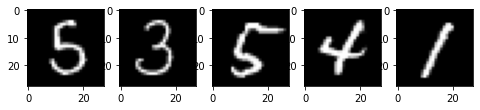

In [ ]:
# Plot a few images from n  
f, ax = plt.subplots(1,5, figsize=(8,6))
for i,a in enumerate(range(n,n+5)):
    # START CODE HERE
    ax[i].imshow(test_images[a, :].reshape((28,28)), cmap='gray')
    # END CODE HERE

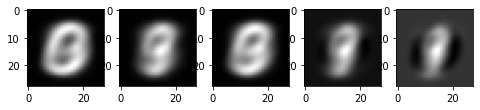

In [ ]:
# Get the prediction from the model 
# START CODE HERE
test_images_hat = ae_model.predict(test_images)
# END CODE HERE

# ... and plot them 
f, ax = plt.subplots(1,5, figsize=(8,6))
for i,a in enumerate(range(n,n+5)):
    # START CODE HERE
    ax[i].imshow(test_images_hat[a, :].reshape((28,28)), cmap='gray')
    # END CODE HERE

Do the same ( = build a new model) with a latent dimension that is largely higher than 2. Compare the visualizations and the images that are rebuilt. 

**Answer:** Comparing the images above (2 neurons in the hidden layer) and below (392 neurons in the hidden layer), we can see that the images above are somewhat similar to the representation seen with the two first components of the PCA (since with a smaller hidden size we compress the data), while the ones below (with many neurons in the hidden layer, but still less than the number of neurons on the input) can somehow copy (not perfectly) the input. 

Model: "ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_72 (Dense)            (None, 392)               307720    
                                                                 
 dense_73 (Dense)            (None, 784)               308112    
                                                                 
Total params: 615,832
Trainable params: 615,832
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
469/469 [==============================] - 7s 15ms/step - loss: 0.5299 - val_loss: 0.3097
Epoch 2/10
469/469 [==============================] - 6s 14ms/step - loss: 0.2581 - val_loss: 0.2115
Epoch 3/10
469/469 [==============================] - 6s 13ms/step - loss: 0.1916 - val_loss: 0.1672
Epoch 4/10
46

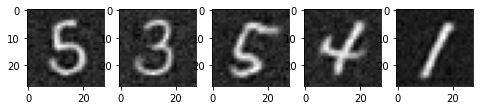

In [ ]:
# START CODE HERE
# Input layer
input_layer = Input(shape=(784,))

# Encoding layer
latent_view = Dense(392)(input_layer)

# Decoding layer
output_layer = Dense(784)(latent_view)

ae_model = Model(input_layer, output_layer, name='ae_model')
ae_model.summary()

loss = 'MSE'
optimizer = SGD(learning_rate=1e-1) 

ae_model.compile(optimizer=optimizer, loss=loss)

batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(train_images,
                       train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images, test_images))
                       
# Get the prediction from the model 
# START CODE HERE
test_images_hat = ae_model.predict(test_images)
# END CODE HERE

# ... and plot them 
f, ax = plt.subplots(1,5, figsize=(8,6))
for i,a in enumerate(range(n,n+5)):
    # START CODE HERE
    ax[i].imshow(test_images_hat[a, :].reshape((28,28)), cmap='gray')
    # END CODE HERE
# END CODE HERE

## Denoising auto-encoder 

Now, we can implement a **de-noising autoencoder**. The following function will transform an array of images by adding it random noise. Create a new autoencoder model, this time with **more layers** and **non-linear activations** (like the ReLU) and train it to rebuild the de-noised images. Display some testing images, with noise, and re-built. 

In [ ]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return noisy_array

In [ ]:
# Create a copy of the data with added noise
noisy_train_images = noise(train_images)
noisy_test_images = noise(test_images)

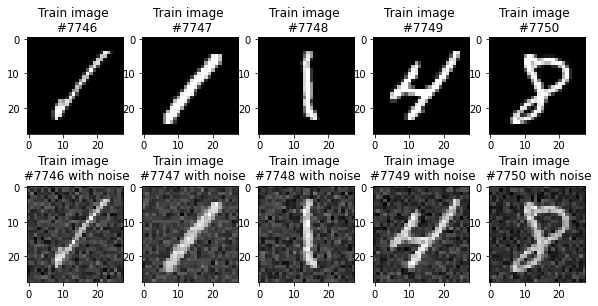

In [ ]:
# Visualize some of the images with noise against the originals
# START CODE HERE

# Select a few images at random: look from n
n = np.random.randint(0,len(test_images)-5)

f, ax = plt.subplots(2,5, figsize=(10,5))
for i,a in enumerate(range(n,n+5)):
    # START CODE HERE
    ax[0,i].imshow(train_images[a, :].reshape((28,28)), cmap='gray')
    ax[0,i].set_title('Train image \n #' + str(a))
    ax[1,i].imshow(noisy_train_images[a, :].reshape((28,28)), cmap='gray')
    ax[1,i].set_title('Train image \n #' + str(a) + ' with noise')
    # END CODE HERE
# END CODE HERE

In [ ]:
# Build a new model with more layers and Relu activations

# START CODE HERE
# Input layer
input_layer = Input(shape=(784,))

# Encoding layers
encoding_layer_0 = Dense(392, activation='relu')(input_layer)
encoding_layer_1 = Dense(196, activation='relu')(encoding_layer_0)

# Decoding layers
decoding_layer_0 = Dense(392, activation='relu')(encoding_layer_1)
output_layer = Dense(784, activation='sigmoid')(decoding_layer_0)

ae_model = Model(input_layer, output_layer, name='ae_model')
ae_model.summary()
# END CODE HERE

Model: "ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_74 (Dense)            (None, 392)               307720    
                                                                 
 dense_75 (Dense)            (None, 196)               77028     
                                                                 
 dense_76 (Dense)            (None, 392)               77224     
                                                                 
 dense_77 (Dense)            (None, 784)               308112    
                                                                 
Total params: 770,084
Trainable params: 770,084
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from os import setgid
# Compile it but here, use noised data as inputs !
# START CODE HERE
loss = 'mse'
optimizer = SGD(learning_rate=1e-1) 

ae_model.compile(optimizer=optimizer, loss=loss)

batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(noisy_train_images,
                       train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(noisy_test_images, test_images))
                       

# END CODE HERE

Epoch 1/10
469/469 [==============================] - 9s 18ms/step - loss: 0.8621 - val_loss: 0.7779
Epoch 2/10
469/469 [==============================] - 8s 17ms/step - loss: 0.7429 - val_loss: 0.7150
Epoch 3/10
469/469 [==============================] - 8s 17ms/step - loss: 0.6905 - val_loss: 0.6747
Epoch 4/10
469/469 [==============================] - 8s 17ms/step - loss: 0.6605 - val_loss: 0.6529
Epoch 5/10
469/469 [==============================] - 8s 17ms/step - loss: 0.6435 - val_loss: 0.6397
Epoch 6/10
469/469 [==============================] - 8s 17ms/step - loss: 0.6318 - val_loss: 0.6294
Epoch 7/10
469/469 [==============================] - 8s 18ms/step - loss: 0.6224 - val_loss: 0.6208
Epoch 8/10
469/469 [==============================] - 8s 17ms/step - loss: 0.6141 - val_loss: 0.6129
Epoch 9/10
469/469 [==============================] - 8s 17ms/step - loss: 0.6066 - val_loss: 0.6058
Epoch 10/10
469/469 [==============================] - 8s 17ms/step - loss: 0.5998 - val_lo

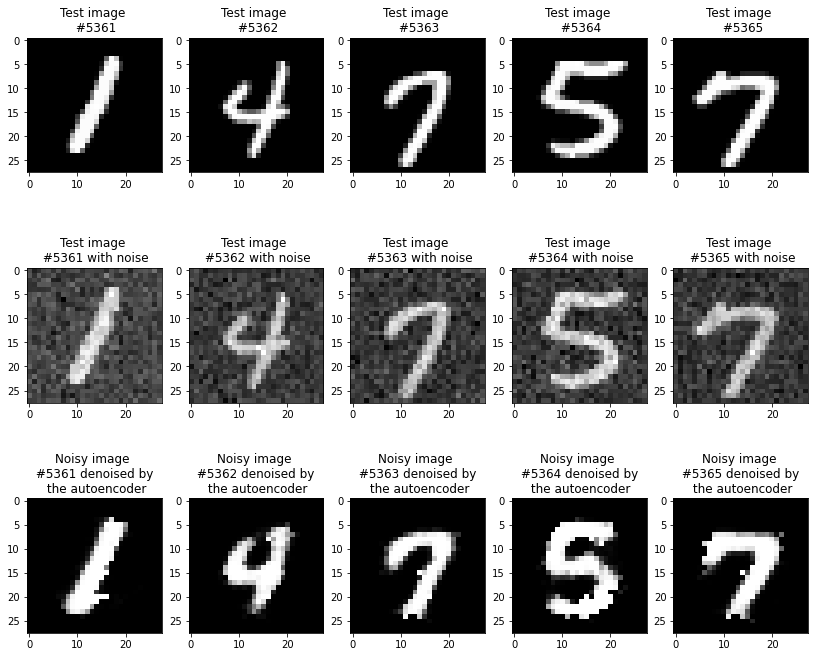

In [ ]:
# Visualize the images rebuilt by the model !
# Get the prediction from the model 
# START CODE HERE
noisy_test_images_hat = ae_model.predict(noisy_test_images)
# END CODE HERE

# ... and plot them 
f, ax = plt.subplots(3,5, figsize=(14,12))
for i,a in enumerate(range(n,n+5)):
    # START CODE HERE
    ax[0,i].imshow(test_images[a, :].reshape((28,28)), cmap='gray')
    ax[0,i].set_title('Test image \n #' + str(a))
    ax[1,i].imshow(noisy_test_images[a, :].reshape((28,28)), cmap='gray')
    ax[1,i].set_title('Test image \n #' + str(a) + ' with noise')
    ax[2,i].imshow(noisy_test_images_hat[a, :].reshape((28,28)), cmap='gray')
    ax[2,i].set_title('Noisy image \n #' + str(a) + ' denoised by \n the autoencoder')
    # END CODE HERE
# END CODE HERE

**Assuming that we normalize the images to be in the 0-1 range, what other loss function could we use ?**

**Answer:** We would use a categorical cross-entropy loss function because it's a multiclass classification problem.